<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FSneuron_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [58]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [59]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
            h_base = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
            d_base = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
            T_base = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif num_params == 8:
            h_base = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
            d_base = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
            T_base = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif num_params == 12:
            h_base = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
            d_base = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
            T_base = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif num_params == 16:
            h_base = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
            d_base = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
            T_base = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        # Use Laplace noise
        self.h = nn.Parameter(h_base + torch.distributions.Laplace(0, 0.1).sample(h_base.size()))
        self.d = nn.Parameter(d_base + torch.distributions.Laplace(0, 0.1).sample(d_base.size()))
        self.T = nn.Parameter(T_base + torch.distributions.Laplace(0, 0.1).sample(T_base.size()))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 0.11531715095043182
Epoch 1001/20000, Loss: 0.03969821706414223
Epoch 2001/20000, Loss: 0.0388929583132267
Epoch 3001/20000, Loss: 0.03878343105316162
Epoch 4001/20000, Loss: 0.03879479318857193
Epoch 5001/20000, Loss: 0.038795746862888336
Epoch 6001/20000, Loss: 0.03879594802856445
Epoch 7001/20000, Loss: 0.038796231150627136
Epoch 8001/20000, Loss: 0.038795799016952515
Epoch 9001/20000, Loss: 0.03879614546895027
Epoch 10001/20000, Loss: 0.03879614174365997
Epoch 11001/20000, Loss: 0.03879794478416443
Epoch 12001/20000, Loss: 0.03879513964056969
Epoch 13001/20000, Loss: 0.03879615664482117
Epoch 14001/20000, Loss: 0.03879678249359131
Epoch 15001/20000, Loss: 0.038796380162239075
Epoch 16001/20000, Loss: 0.03879721090197563
Epoch 17001/20000, Loss: 0.03879612684249878
Epoch 18001/20000, Loss: 0.038796111941337585
Epoch 19001/20000, Loss: 0.03879619017243385
Loss values: [0.11531715095043182, 0.045292310416698456, 0.04089910164475441, 0.04030642285943031, 0.03997677

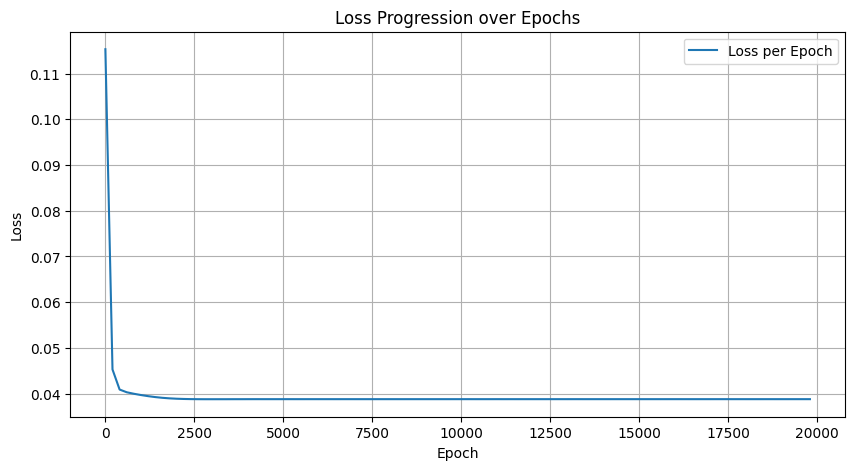

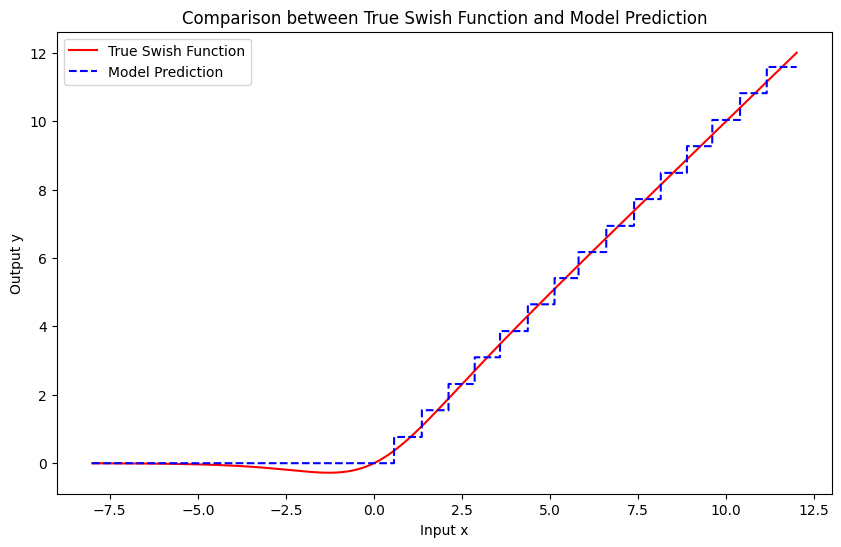

In [60]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.3667956292629242
Epoch 1001/20000, Loss: 0.01501209381967783
Epoch 2001/20000, Loss: 0.010995321907103062
Epoch 3001/20000, Loss: 0.01010814681649208
Epoch 4001/20000, Loss: 0.010359730571508408
Epoch 5001/20000, Loss: 0.009967920370399952
Epoch 6001/20000, Loss: 0.009261706843972206
Epoch 7001/20000, Loss: 0.009078333154320717
Epoch 8001/20000, Loss: 0.008964498527348042
Epoch 9001/20000, Loss: 0.00895540788769722
Epoch 10001/20000, Loss: 0.008952675387263298
Epoch 11001/20000, Loss: 0.008948338218033314
Epoch 12001/20000, Loss: 0.008946528658270836
Epoch 13001/20000, Loss: 0.008946683257818222
Epoch 14001/20000, Loss: 0.008946512825787067
Epoch 15001/20000, Loss: 0.008946366608142853
Epoch 16001/20000, Loss: 0.008946609683334827
Epoch 17001/20000, Loss: 0.008946654386818409
Epoch 18001/20000, Loss: 0.008946551941335201
Epoch 19001/20000, Loss: 0.008946563117206097
Loss values: [0.3667956292629242, 0.03359200060367584, 0.020776301622390747, 0.01610581949353218, 

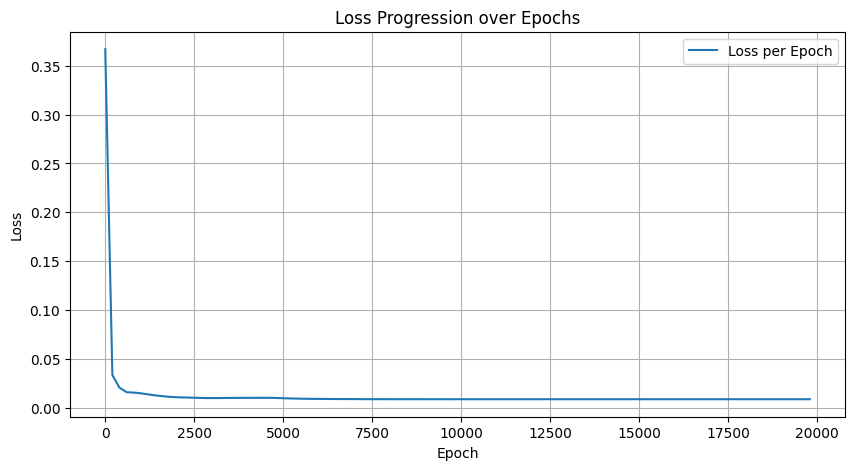

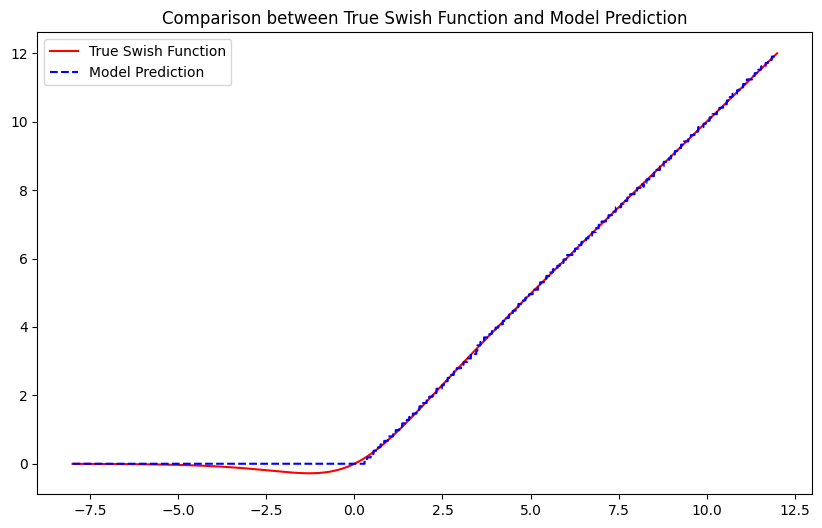

In [61]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
#plt.xlabel('Input x')
#plt.ylabel('Output y')
plt.legend()

plt.show()

K=12

Epoch 1/20000, Loss: 0.08840784430503845
Epoch 1001/20000, Loss: 0.0021877046674489975
Epoch 2001/20000, Loss: 0.002078579505905509
Epoch 3001/20000, Loss: 0.002032429911196232
Epoch 4001/20000, Loss: 0.0020472747273743153
Epoch 5001/20000, Loss: 0.0020414514001458883
Epoch 6001/20000, Loss: 0.0020661288872361183
Epoch 7001/20000, Loss: 0.0019689348991960287
Epoch 8001/20000, Loss: 0.0019475684966892004
Epoch 9001/20000, Loss: 0.0017671447712928057
Epoch 10001/20000, Loss: 0.001559412688948214
Epoch 11001/20000, Loss: 0.0015315298223868012
Epoch 12001/20000, Loss: 0.0014838807983323932
Epoch 13001/20000, Loss: 0.0014562587020918727
Epoch 14001/20000, Loss: 0.0014696144498884678
Epoch 15001/20000, Loss: 0.0014877504436299205
Epoch 16001/20000, Loss: 0.0014802914811298251
Epoch 17001/20000, Loss: 0.0015017378609627485
Epoch 18001/20000, Loss: 0.001520761288702488
Epoch 19001/20000, Loss: 0.0015209950506687164
Loss values: [0.08840784430503845, 0.009335404261946678, 0.002900053048506379, 

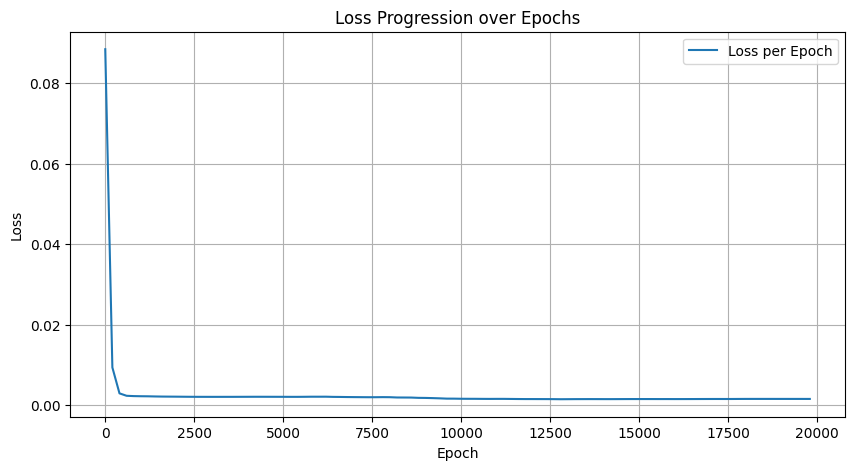

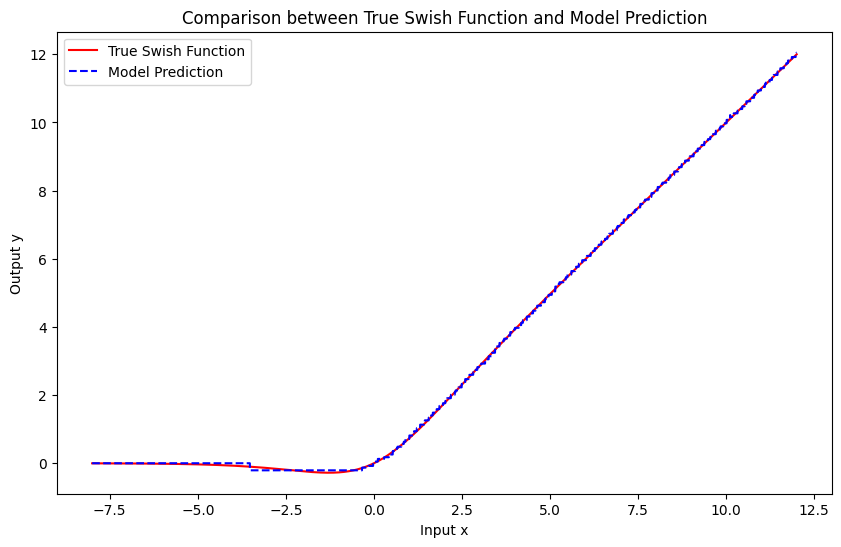

In [62]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.17350555956363678
Epoch 1001/20000, Loss: 0.001875871093943715
Epoch 2001/20000, Loss: 0.0016261533601209521
Epoch 3001/20000, Loss: 0.001484318869188428
Epoch 4001/20000, Loss: 0.0012354440987110138
Epoch 5001/20000, Loss: 0.0011302500497549772
Epoch 6001/20000, Loss: 0.001069426303729415
Epoch 7001/20000, Loss: 0.0010449239052832127
Epoch 8001/20000, Loss: 0.0010329507058486342
Epoch 9001/20000, Loss: 0.00104275974445045
Epoch 10001/20000, Loss: 0.0010419130558148026
Epoch 11001/20000, Loss: 0.0010444645304232836
Epoch 12001/20000, Loss: 0.0010358898434787989
Epoch 13001/20000, Loss: 0.0010411877883598208
Epoch 14001/20000, Loss: 0.001038821297697723
Epoch 15001/20000, Loss: 0.0010393476113677025
Epoch 16001/20000, Loss: 0.0010382981272414327
Epoch 17001/20000, Loss: 0.0010249841725453734
Epoch 18001/20000, Loss: 0.00102300348225981
Epoch 19001/20000, Loss: 0.0010258291149511933
Loss values: [0.17350555956363678, 0.009015580639243126, 0.003166736802086234, 0.00

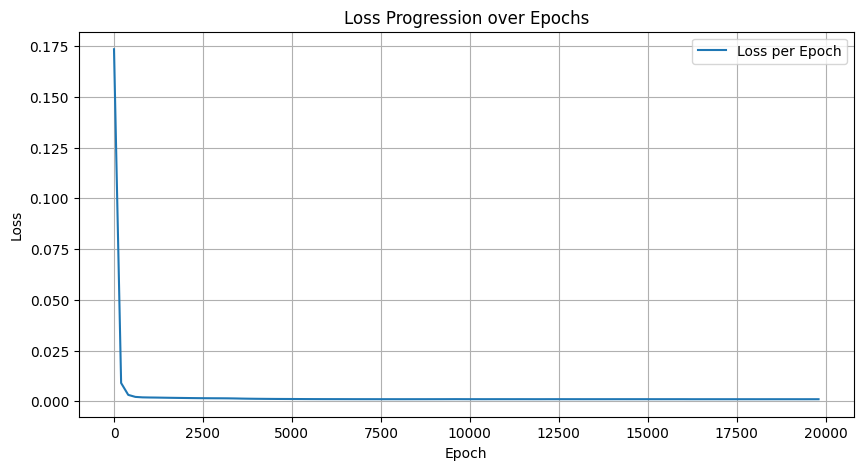

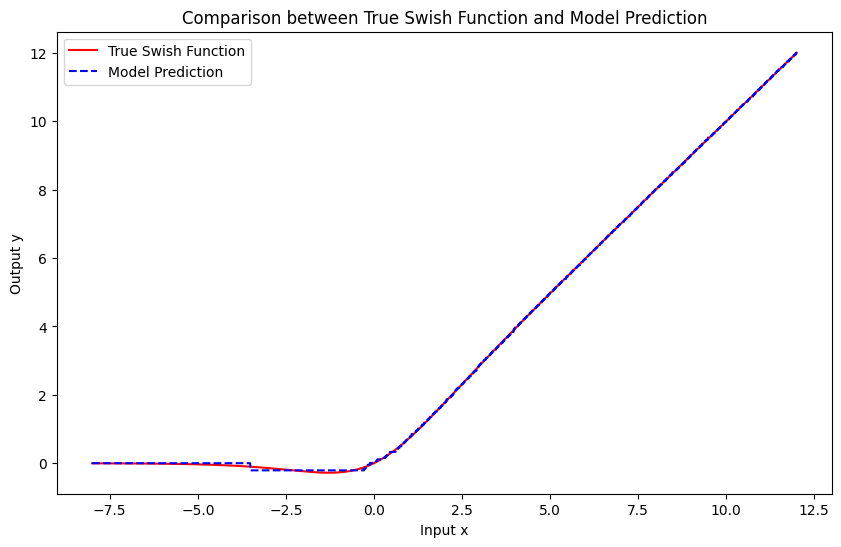

In [63]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()